# **Modeling and Evaluation Notebook**
## Objectives

Address Business Requirement 2:

    Develop a Machine Learning model to classify cherry leaves as Healthy or Infected, enabling reliable detection of powdery mildew in the field.

📂 Inputs
📁 Dataset

    inputs/datasets/raw/cherry-leaves/train

    inputs/datasets/raw/cherry-leaves/validation

    inputs/datasets/raw/cherry-leaves/test

## Insights from the Previous (Data Visualization) Notebook

     Image Resizing & Standardization → All images resized to 128x128x3 for consistent model input.

     Balanced Class Distribution → Verified across train/val/test sets to prevent bias.

     Brightness & Pixel Variability → Confirmed statistically via t-test; supports class differentiation.

     Feature Space Visualizations:

        PCA showed partial linear separability.

        t-SNE revealed more structure but some overlap.

        UMAP showed clearer separation, highlighting non-linear geometry — suggesting strong model potential.

## Outputs


## Additional Comments


## Import packages for notebook

In [14]:
import os
import joblib
import sys
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Add the ressource directory to our path to be able to load relevant functions
sys.path.append('./src')

## Set working directory

As the notebooks are set in a subfolder of this repo we need to adjust the working directory so files can be accessed properly. 

First we check our current working directory.

In [2]:
current_dir = os.getcwd()
current_dir

'e:\\Projects\\Code-I\\vscode-projects\\PP5-predictive_analysis\\jupyter_notebooks'

Now we can change the directory to the parent folder that contains the complete repo. We will also print our new working directory so we can check everything worked out as planned.

In [3]:
# Only change the directory if not already at the repo root
current_dir = os.getcwd()
target_dir = os.path.abspath(os.path.join(current_dir, os.pardir))  # One level up

# Check if we're already in the repo root
if os.path.basename(current_dir) == 'jupyter_notebooks':
    os.chdir(target_dir)
    current_dir = os.getcwd()
    print(f"Working directory set to: {os.getcwd()}")
else:
    print(f"Current working directory remains: {current_dir}")

Working directory set to: e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis


## Define data directories

In [4]:
# define variable for data directory
data_dir = os.path.join(os.getcwd(), 'inputs/datasets/raw/cherry-leaves')
# define variable for train set directory
train_dir = os.path.join(data_dir, 'train')
# define variable for test set directory
test_dir = os.path.join(data_dir, 'test')
# define variable for test set directory
val_dir = os.path.join(data_dir, 'validation')

## Define output directory

In [5]:
# Set the current version
version = 'v1'
# Define the  directory
output_dir = os.path.join(current_dir, 'outputs', version)

# Check if the versioned output directory already exists
if os.path.exists(output_dir):
    print(f"Output directory '{output_dir}' already exists. "
          "Please create a new version.")
else:
    os.makedirs(output_dir)
    print(f"Created output directory: '{output_dir}'")

Output directory 'e:\Projects\Code-I\vscode-projects\PP5-predictive_analysis\outputs\v1' already exists. Please create a new version.


## Load image shape definition

In [6]:
# define image dimensions and save for reuse
img_shape = joblib.load(f"{output_dir}/img_shape.pkl")
img_shape

(128, 128, 3)

## Recount number of images in train, test and validation data

In this step we will have another look at size and distribution of the datasets

* train - healthy: 1472 images
* train - diseased: 1472 images
* validation - healthy: 315 images
* validation - diseased: 315 images
* test - healthy: 317 images
* test - diseased: 317 images


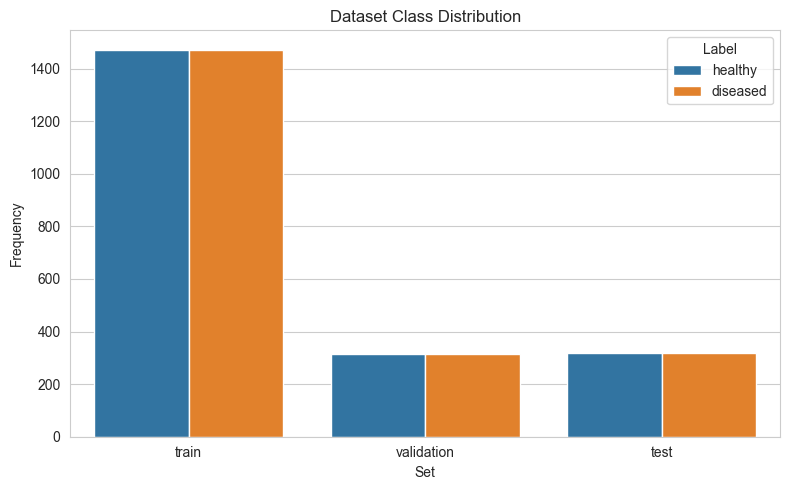

In [8]:
from exploration_visualization import count_images_for_class
from modelling import get_split_counts
from modelling import plot_split_distribution

labels = ['healthy', 'diseased']
splits = ['train', 'validation', 'test']

df_freq = get_split_counts(data_dir, splits=splits, labels=labels)
plot_split_distribution(df_freq, save_path="outputs/labels_distribution.png")


This distribution does point toward applying data augmentation, though not because of imbalance — it's balanced — but because of limited data volume, especially in the validation and test sets.
In total we have about 4200 images, this is modest for training deep learning models.
Augmentation will help with model generalization as it helps the model learn to handle varied real-world conditions (lighting, angle, background). It will also regularize the model and reduce overfitting.

## Data augmentation

We will use the image data generator from keras, as it is an out of the box generator that will (based on our settings) apply the standard modifications to distort our images and create new data. This includes rotation width and height shift, zooming in and out, flipping the image, changing brightness and shearing.

### Initialize image generator

In [10]:
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_aug = ImageDataGenerator(rescale=1./255)

We will augment  our train set with the train_aug definition.
For the validation & test sets we will not augment and just rescale=1./255. To leave them untouched to reflect real-world performance.

### Augment training data set

---

In [11]:
# Create data generator from directory
train_set = train_aug.flow_from_directory(
    train_dir,
    target_size=img_shape[:2],  # e.g. (128, 128)
    color_mode='rgb',
    batch_size=16,
    class_mode='binary',          # or 'categorical' if one-hot encoded
    shuffle=True
)

# Inspect class labels
print(train_set.class_indices)

Found 2944 images belonging to 2 classes.
{'diseased': 0, 'healthy': 1}


### Rescale validation data set

---

In [12]:
validation_set = val_test_aug.flow_from_directory(
    val_dir,
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=16,
    class_mode='binary',
    shuffle=False  # Usually no shuffle for validation/test
)

Found 630 images belonging to 2 classes.


### Rescale test data set

---

In [13]:
test_set = val_test_aug.flow_from_directory(
    test_dir,
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

Found 634 images belonging to 2 classes.


### Plot exemplary augmented training images

---

(16, 128, 128, 3)


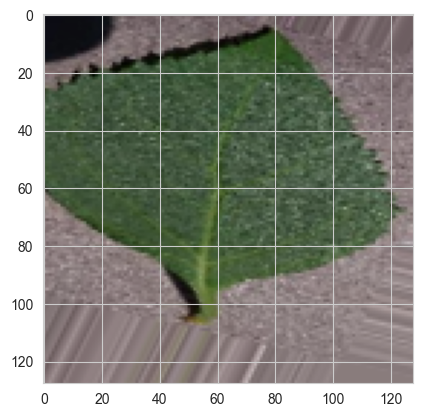

(16, 128, 128, 3)


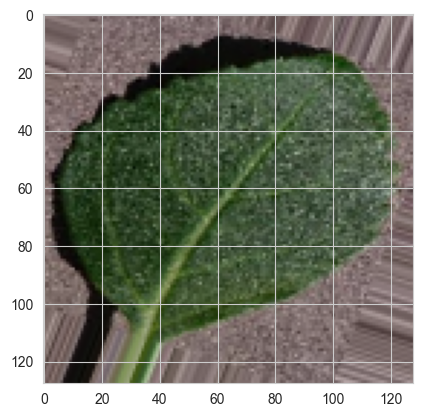

(16, 128, 128, 3)


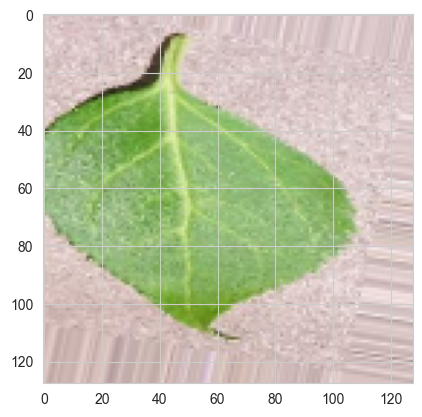

In [16]:
for i in range(3):
    img, label = next(train_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Plot exemplary rescaled validation images

---

(16, 128, 128, 3)


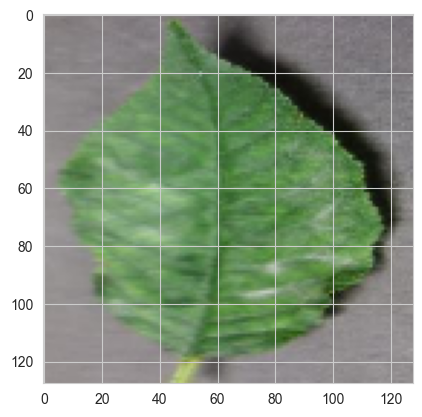

(16, 128, 128, 3)


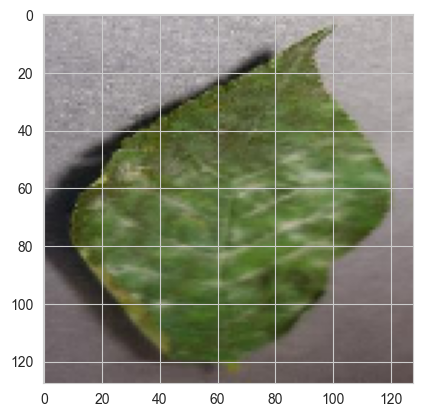

(16, 128, 128, 3)


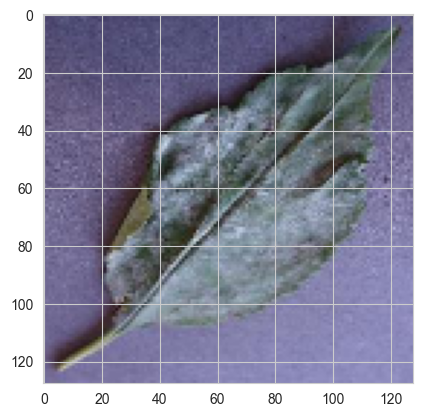

In [18]:
for i in range(3):
    img, label = next(validation_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Plot exemplary rescaled test images

---

(16, 128, 128, 3)


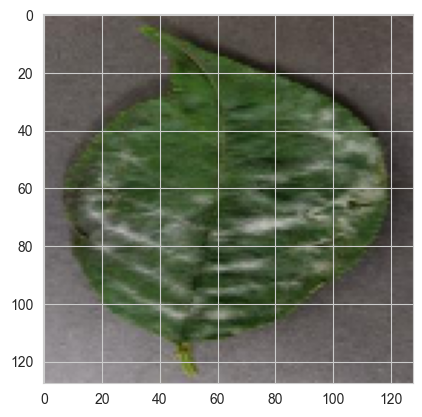

(16, 128, 128, 3)


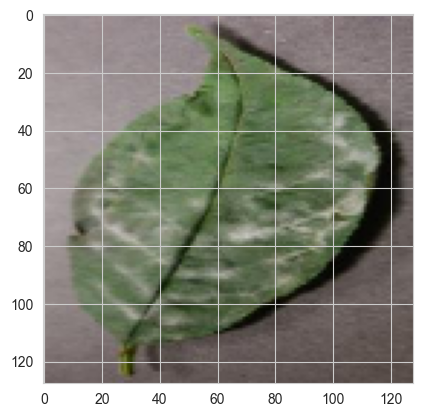

(16, 128, 128, 3)


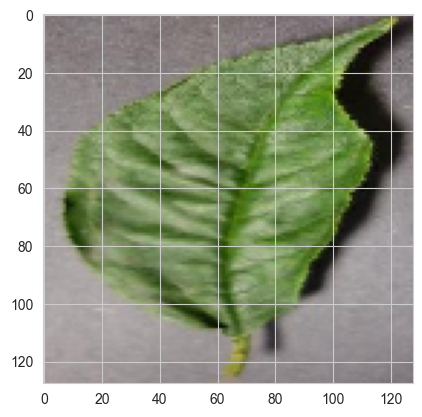

In [19]:
for i in range(3):
    img, label = next(test_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save class indices

In [20]:
joblib.dump(value=train_set.class_indices,
            filename=f"{output_dir}/class_indices.pkl")

['e:\\Projects\\Code-I\\vscode-projects\\PP5-predictive_analysis\\outputs\\v1/class_indices.pkl']

---

## Modelling

---